In [137]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [138]:
# чтение данных
data=pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Предварительная обработка не требуется, данные уже закодированы и нормализованы.

In [139]:
X, y = data.drop(['Activity'], axis=1), data['Activity']

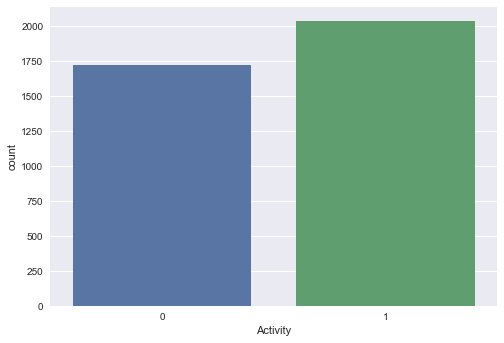

In [140]:
sns.countplot(data=data, x='Activity');

In [141]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Модель логистической регрессии

In [142]:
log_reg=linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_test=log_reg.predict(X_test)
print ('f1_score на тестовом наборе данных:{:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))


f1_score на тестовом наборе данных:0.78


c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## GridSearchCV

In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga', 'newton-cg'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.8 s
Wall time: 1min 5s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Вывод** Метрика не улучшилась

## RandomizedSearchCV

In [144]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.66 s
Wall time: 24.5 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Вывод** Добавление нового параметра - сила регуляризации - помог улучшить метрику за более быстрое время

## Hyperopt

In [145]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

In [146]:
# пространство гиперпараметров
space={'penalty': hp.choice(label='penalry', options=['l2', 'none']) ,
    'solver': hp.choice(label='solver', options=['sag']),
    'C': hp.quniform('C', 0.01, 1, 10)
}

In [147]:
# объявляем функцию
random_state = 42
def hyperopt_lr(cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    #params = space
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
       
        random_state=random_state,
        max_iter=1000
    )

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [148]:
# начинаем подбор гиперпараметров
%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [01:49<00:00,  2.20s/trial, best loss: -0.8931390406800243]
Наилучшие значения гиперпараметров {'C': 0.0, 'penalry': 0, 'solver': 0}


**Вывод** если задавать параметры, то возникает ошибка, решение которой в Slack до сих пор не представлено, поэтому данный алгоритм не подбирает оптимальные значения гиперпараметров.

## Optuna

In [149]:
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical(name='penalty', choices=['l2', 'none'])
  solver = trial.suggest_categorical(name='solver', choices=['sag'])
  C = trial.suggest_float(name='C', low=0.01, high=1, step=10, log=False)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [150]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-09 14:48:02,139] A new study created in memory with name: LogisticRegression
c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.01, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0.01, 0.01].
  warnings.warn(
[I 2022-11-09 14:48:06,319] Trial 0 finished with value: 0.8230723251643753 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.01}. Best is trial 0 with value: 0.8230723251643753.
c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.01, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0.01, 0.01].
  warnings.warn(
[I 2022-11-09 14:48:10,357] Trial 1 finished with value: 0.8230723251643753 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.01}. Best is trial 0 with value: 0.8230723251643753.
c:\Use

In [151]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'sag', 'C': 0.01}
f1_score на обучающем наборе: 0.89


In [155]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


f1_score на тестовом наборе: 0.77


c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Общий вывод** Для логистической регрессии самым оптимальный алгоритмов поиска гиперпараметров является Optuna, как по времени решения, так и по метрике. При гиперапараметрах {'penalty': 'none', 'solver': 'sag', 'C': 0.01} достигается максимальный показатель метрики - 0,77

# Модель случайного леса

In [156]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [157]:
rfc=ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_test=rfc.predict(X_test)
print ('f1_score на тестовом наборе данных:{:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

f1_score на тестовом наборе данных:0.80


**Вывод:** Метрика в модели рандомного леса с параметрами по умолчанию выше, чем в логистической регрессии. Теперь попытаемся улучшить гиперпараметры

## GridSearchCV

In [158]:
param_grid = {
    'min_samples_leaf': [5, 10, 15],
    'max_depth': list(np.linspace(20, 40, 10, dtype=int)),
    'criterion':['entropy','gini']
}
            
random_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 

y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 2.33 s
Wall time: 48.2 s
f1_score на тестовом наборе: 0.75
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 15}


**Вывод** Из заданных гиперпараметров алгоритм подобрал показатели так, что значение метрики ухудшилось

## RandomizedSearchCV

In [ ]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
y_test_pred = random_search_tree.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 1.8 s
Wall time: 26.7 s
f1_score на тестовом наборе: 0.76
Наилучшие значения гиперпараметров: {'min_samples_leaf': 68, 'max_depth': 3, 'criterion': 'entropy'}


**Вывод** Метрика чуть улучшилась, но все равно с параметрами по умолчанию модель показывает лучшие результаты

## Hyperopt

In [159]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [160]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [161]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [01:00<00:00,  3.05s/trial, best loss: -0.9743433109346366]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 110.0}


In [162]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


**Вывод** Метрика на тестовом наборе улучшилась. 

## Optuna

In [163]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [164]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-09 14:56:49,229] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2022-11-09 14:56:53,964] Trial 0 finished with value: 0.9463741620962828 and parameters: {'n_estimators': 220, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9463741620962828.
[I 2022-11-09 14:56:58,837] Trial 1 finished with value: 0.929551692589204 and parameters: {'n_estimators': 290, 'max_depth': 37, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9463741620962828.
[I 2022-11-09 14:57:02,100] Trial 2 finished with value: 0.9595129375951292 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9595129375951292.
[I 2022-11-09 14:57:05,923] Trial 3 finished with value: 0.9457317073170731 and parameters: {'n_estimators': 250, 'max_depth': 31, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9595129375951292.
[I 2022-11-09 14:57:08,169] Trial 4 finished with value: 0.9567600487210719 and parameters: {'n_estimators': 140, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9595

In [165]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 31, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.97


In [166]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81


**Вывод** На тестовом наборе подобраны самые лучшие показатели гиперпараметров, так что метрика улучшилась

**Общий вывод** Модель рандомного леса в целом справляется лучше, чем логистрическая регрессия. Самые лучшие показатели гиперпараметров подобраны с помощью алгоритма Optuna, наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 31, 'min_samples_leaf': 3}, метрика при таких параметрах равняется 0,81.